# NYC Department of Sanitation Complaints - 311 
### 2018-2023

#### _Overview_ 
This notebook parses the 311 DSNY cleanliness related complaints for the 2018 to 2023 time span, and aggregates the sightings to the census block group spatial unit. One-hot encoding is used to create a boolean column per variables to sum the total count of complaints. 

- **Sanitation Type** is simplified to a new columns called 'sanitation_type' with the following classifications: Dead_Animal, Dog_waste, Illegal_Dumping, Trash, Trash_MissedService, Trash_Overflowing, Trash_Time, and Trash_Unsecure. In the final census block dataset these are prefixed with `s_` indicating the sanitation type with location information (Residential or Street).

Caveats: 

    The final dataset has duplicate polygons: 1 per year 
    Duplicate reports on the same day from the same address are dropped. 


<u>Citations<u>
    
    MLA Format:
    NYC OpenData, 311 Service Requests from 2010 to Present, https://data.cityofnewyork.us/Social-Services/311-Service-Requests-from-2010-to-Present/erm2-nwe9.

    LaTeX Format:
    \bibitem{311ServiceRequests}
    NYC OpenData. \emph{311 Service Requests from 2010 to Present}. https://data.cityofnewyork.us/Social-Services/311-Service-Requests-from-2010-to-Present/erm2-nwe9.



In [1]:
from datetime import datetime, timedelta
import geopandas as gpd
import json
import pandas as pd
import mapclassify
import matplotlib.pyplot as plt
import numpy as np
import os
import requests
from io import StringIO
import warnings

warnings.filterwarnings('ignore')

pd.set_option('display.max_columns', None)
pd.set_option("display.max_rows", None)
np.set_printoptions(threshold=np.inf)

In [70]:
# 311 Complaints (all)
params_311 = {
    '$where': "created_date between '2019-01-01T00:00:00' and '2019-12-31T23:59:59'",
    '$limit': 50000  # Limit the number of records, adjust as needed
}
url_311 = 'https://data.cityofnewyork.us/resource/erm2-nwe9.geojson'
# https://data.cityofnewyork.us/Social-Services/311-Service-Requests-from-2010-to-Present/erm2-nwe9

In [71]:
complaints_response = requests.get(url_311, params=params_311)
complaints_json = complaints_response.json()
complaints_gdf = gpd.GeoDataFrame.from_features(complaints_json['features'])
print(len(complaints_gdf))
complaints_gdf.head()

50000


geometry location_state facility_type  \
0  POINT (-73.92774 40.58508)                         None   
1  POINT (-73.96455 40.79693)                         None   
2  POINT (-73.92811 40.85592)                         None   
3  POINT (-73.87627 40.75234)                         None   
4  POINT (-73.95542 40.64415)                         None   

              intersection_street_2             city location_zip  \
0  BELT PARKWAY EXIT    9 WESTBOUND         BROOKLYN                
1                  WEST  103 STREET         NEW YORK                
2                ST NICHOLAS AVENUE         NEW YORK                
3                         37 AVENUE  JACKSON HEIGHTS                
4                    BEDFORD AVENUE         BROOKLYN                

  park_borough            latitude road_ramp             created_date agency  \
0     BROOKLYN   40.58507695307629      None  2019-12-31T23:59:11.000   NYPD   
1    MANHATTAN   40.79692992181987      None  2019-12-31T23:58:54.000   NYPD   
2    MANHATTAN  40.855918860412444      None  2019-12-31T23:58:03.000   NYPD   
3       QUEENS  40.752335548300096      None  2019-12-31T23:57:19.000   NYPD   
4     BROOKLYN    40.6441452622389      None  2019-12-31T23:56:52.000   NYPD   

  park_facility_name location_address                      agency_name  \
0        Unspecified                   New York City Police Department   
1        Unspecified                   New York City Police Department   
2        Unspecified                   New York City Police Department   
3        Unspecified                   New York City Police Department   
4        Unspecified                   New York City Police Department   

         descriptor         bbl location_city open_data_channel_type  \
0  Banging/Pounding  3088440010                               ONLINE   
1  Loud Music/Party  1018360001                                PHONE   
2  Loud Music/Party        None                               MOBILE   
3  Loud Music/Party  4014640015                               ONLINE   
4         No Access  3051670072                                PHONE   

                     cross_street_2 bridge_highway_direction  \
0  BELT PARKWAY EXIT    9 WESTBOUND                     None   
1                  WEST  103 STREET                     None   
2                ST NICHOLAS AVENUE                     None   
3                         37 AVENUE                     None   
4                    BEDFORD AVENUE                     None   

            longitude bridge_highway_segment       street_name  \
0  -73.92773945669528                   None     EMMONS AVENUE   
1  -73.96455113216999                   None   COLUMBUS AVENUE   
2   -73.9281139621785                   None  WEST  192 STREET   
3  -73.87626643726503                   None         91 STREET   
4  -73.95542192797127                   None    CORTELYOU ROAD   

       incident_address address_type incident_zip unique_key  \
0    3939 EMMONS AVENUE         None        11229   45278137   
1   865 COLUMBUS AVENUE         None        10025   45281589   
2  558 WEST  192 STREET         None        10040   45283574   
3       35-18 91 STREET         None        11372   45278249   
4   2310 CORTELYOU ROAD         None        11226   45282332   

        complaint_type y_coordinate_state_plane  status bridge_highway_name  \
0   Noise - Commercial                   152444  Closed                None   
1  Noise - Residential                   229622  Closed                None   
2  Noise - Residential                   251120  Closed                None   
3  Noise - Residential                   213397  Closed                None   
4     Blocked Driveway                   173959  Closed                None   

                location_type due_date taxi_company_borough  \
0         Club/Bar/Restaurant     None                 None   
1  Residential Building/House     None                 None   
2  Residential Building/House     None     

In [72]:
complaints_gdf.location_type.value_counts()

Street/Sidewalk                  8747
RESIDENTIAL BUILDING             8655
Sidewalk                         8256
Residential Building/House       5520
Street                           2676
Store/Commercial                  512
N/A                               349
Mixed Use                         341
Above Address                     274
Street/Curbside                   247
Comercial                         242
1-2 Family Dwelling               235
Club/Bar/Restaurant               220
Restaurant/Bar/Deli/Bakery        170
Bike Lane                         163
Park                              161
Lot                               131
3+ Family Apt. Building           129
Commercial Building               110
3+ Family Apartment Building      101
Curb                               84
Residential Building               69
Highway                            58
Residential                        55
Taxi                               49
Restaurant                         45
Other (Expla

In [73]:
complaints_gdf.agency.value_counts()

NYPD     18582
DSNY      9886
HPD       8655
DOT       4713
DEP       2728
DOB       1888
DOHMH     1020
DPR        806
TLC        797
DHS        342
EDC        286
DCA        264
DOITT       14
DFTA        10
DOE          9
Name: agency, dtype: int64

In [74]:
complaints_gdf.descriptor.value_counts()

Loud Music/Party                                                                    4903
Request Large Bulky Item Collection                                                 4303
ENTIRE BUILDING                                                                     3697
No Access                                                                           2732
Banging/Pounding                                                                    2388
APARTMENT ONLY                                                                      2035
Ewaste appointment                                                                  1336
Blocked Hydrant                                                                     1333
Posted Parking Sign Violation                                                       1043
Partial Access                                                                       919
With License Plate                                                                   895
Pothole              

In [75]:
complaints_gdf.complaint_type.value_counts()

Noise - Residential                        6528
HEAT/HOT WATER                             5732
Request Large Bulky Item Collection        4303
Illegal Parking                            4261
Blocked Driveway                           3651
Electronics Waste Appointment              1336
Street Condition                           1326
Street Light Condition                     1120
Missed Collection (All Materials)          1108
Water System                                952
Noise - Street/Sidewalk                     918
Abandoned Vehicle                           895
Traffic Signal Condition                    815
General Construction/Plumbing               802
UNSANITARY CONDITION                        759
Sanitation Condition                        722
Graffiti                                    720
Noise - Vehicle                             712
Noise - Commercial                          706
Dirty Conditions                            704
Derelict Vehicles                       

In [76]:
dsny_complaints_gdf = complaints_gdf[complaints_gdf['agency']=='DSNY']
dsny_complaints_gdf.complaint_type.value_counts()

Request Large Bulky Item Collection    4303
Electronics Waste Appointment          1336
Missed Collection (All Materials)      1108
Sanitation Condition                    722
Graffiti                                707
Dirty Conditions                        704
Derelict Vehicles                       700
Other Enforcement                       163
Litter Basket / Request                  39
Derelict Bicycle                         25
Vacant Lot                               22
Sweeping/Missed                          17
Overflowing Litter Baskets               14
Recycling Enforcement                     7
Collection Truck Noise                    6
Snow                                      6
Sweeping/Inadequate                       4
Adopt-A-Basket                            1
Electronics Waste                         1
Overflowing Recycling Baskets             1
Name: complaint_type, dtype: int64

In [77]:
dsny_complaints_gdf.descriptor.value_counts()

Request Large Bulky Item Collection      4303
Ewaste appointment                       1336
Graffiti                                  707
Derelict Vehicles                         700
15 Street Cond/Dump-Out/Drop-Off          530
1 Missed Collection                       517
E3 Dirty Sidewalk                         299
1R Missed Recycling-All Materials         187
12 Dead Animals                           183
2 Bulk-Missed Collection                  126
E3A Dirty Area/Alleyway                   105
1RG Missed Recycling Paper                 97
E15 Illegal Postering                      82
2R Bulk-Missed Recy Collection             71
E1 Improper Disposal                       61
E2A Storage Of Receptacles                 57
1RB Missed Recycling - M/G/Pl              55
E3B Sidewalk Obstruction                   52
1RO Missed Recycling Organics              51
E8 Canine Violation                        48
10 Litter Basket / Request                 39
E5 Loose Rubbish                  

# Department of Sanitation (DSNY) Complaints Only 

In [100]:
# 311 Complaints (all)
agency = 'DSNY'
complaints = "('Dirty Condition', 'Illegal Dumping', 'Residential Disposal Complaint', 'Dead Animal', 'Residential Disposal Complaint', 'Commercial Disposal Complaint', 'Dumpster Complaint', 'Lot Condition', 'Litter Basket Complaint', 'Institution Disposal Complaint', 'Sanitation Condition', 'Missed Collection (All Materials)', 'Dirty Conditions', 'Litter Basket / Request', 'Vacant Lot', 'Overflowing Litter Baskets', 'Sweeping/Inadequate')"
descriptors_exclude = "('9 Spill/Oil etc','E7 Private Carter Spillage','E1A Litter Basket / Improper Use','15R Street Cond/Ref.W Door','3B Sweeping/Inadequate', 'E4 18\" Law', 'E15 Illegal Postering','10 Litter Basket / Request','22 Weeds','15N Needle/Syringe on Street/Sidewalk','Blocking Sidewalk or Street', 'No Private Carter', 'Broken Glass', 'Private Carter Decal Not Posted', 'Dirt or Gravel', 'Misuse', 'Syringes', 'Debris from Car Accident', 'Trash Not Separated from Recycling', 'Refrigerator or Freezer Door Attached','Storage Area Not Provided', 'Appliances','Recycling Posters Not Posted','Poster or Sign')"
params_311_dsny = {
    '$where': "created_date between '2018-01-01T00:00:00' and '2023-12-31T23:59:59' and agency = '{0}' AND complaint_type IN {1} AND descriptor not in {2}".format(agency, complaints,descriptors_exclude),
    '$limit': 1000000  # Limit the number of records, adjust as needed
}
url_311 = 'https://data.cityofnewyork.us/resource/erm2-nwe9.geojson'
# https://data.cityofnewyork.us/Social-Services/311-Service-Requests-from-2010-to-Present/erm2-nwe9

In [131]:
# For DSNY Complaints, which complaint type and descriptors are there?

# dsny_complaints_gdf = complaints_gdf[complaints_gdf['agency']=='DSNY']

dsny_response = requests.get(url_311, params=params_311_dsny)
dsny_complaints_json = dsny_response.json()
dsny_complaints_gdf = gpd.GeoDataFrame.from_features(dsny_complaints_json['features'])
print(len(dsny_complaints_gdf))
dsny_complaints_gdf.head()

583326


geometry location_state facility_type  \
0  POINT (-73.91458 40.68137)                         None   
1  POINT (-73.98917 40.73970)                         None   
2  POINT (-73.93664 40.80151)                         None   
3  POINT (-73.92564 40.86128)                         None   
4  POINT (-73.93020 40.70267)                         None   

     intersection_street_2      city location_zip park_borough  \
0  THOMAS S BOYLAND STREET  BROOKLYN                  BROOKLYN   
1        PARK AVENUE SOUTH  NEW YORK                 MANHATTAN   
2                 2 AVENUE  NEW YORK                 MANHATTAN   
3          HILLSIDE AVENUE  NEW YORK                 MANHATTAN   
4            WILSON AVENUE  BROOKLYN                  BROOKLYN   

             latitude road_ramp             created_date agency  \
0  40.681371586289174      None  2023-04-12T00:58:10.000   DSNY   
1  40.739701540710676      None  2023-04-12T00:10:36.000   DSNY   
2   40.80150988829055      None  2023-04-11T23:33:44.000   DSNY   
3   40.86128043510794      None  2023-04-11T23:03:45.000   DSNY   
4  40.702667816654724      None  2023-04-11T22:16:44.000   DSNY   

  park_facility_name location_address               agency_name  \
0        Unspecified                   Department of Sanitation   
1        Unspecified                   Department of Sanitation   
2        Unspecified                   Department of Sanitation   
3        Unspecified                   Department of Sanitation   
4        Unspecified                   Department of Sanitation   

            descriptor         bbl location_city open_data_channel_type  \
0      Chronic Dumping  3015150046                                PHONE   
1                Trash  1008500018                               ONLINE   
2      Chronic Dumping  1017860041                               ONLINE   
3                Trash  1021740070                               ONLINE   
4  Construction Debris  3031570027                               ONLINE   

            cross_street_2 bridge_highway_direction           longitude  \
0  THOMAS S BOYLAND STREET                     None   -73.9145761881963   
1        PARK AVENUE SOUTH                     None  -73.98917058840603   
2                 2 AVENUE                     None   -73.9366391378318   
3          HILLSIDE AVENUE                     None  -73.92563537055742   
4            WILSON AVENUE                     None  -73.93020153373776   

  bridge_highway_segment       street_name      incident_address address_type  \
0                   None     MARION STREET     373 MARION STREET      ADDRESS   
1                   None  EAST   21 STREET   19 EAST   21 STREET      ADDRESS   
2                   None  EAST  122 STREET  216 EAST  122 STREET      ADDRESS   
3                   None      NAGLE AVENUE      148 NAGLE AVENUE      ADDRESS   
4                   None     GEORGE STREET     102 GEORGE STREET      ADDRESS   

  incident_zip unique_key   complaint_type y_coordinate_state_plane  \
0        11233   57286261  Illegal Dumping                   187530   
1        10010   57287182  Dirty Condition                   208770   
2        10035   57285192  Illegal Dumping                   231295   
3        10040   57288895    Lot Condition                   253074   
4        11206   57289711    Lot Condition                   195285   

        status bridge_highway_name location_type due_date  \
0  In Progress                None      Sidewalk     None   
1  In Progress                None      Sidewalk     None   
2  In Progress                None      Sidewalk     None   
3  In Progress                None           Lot     None   
4  In Progress                None           Lot     None   

  taxi_company_borough taxi_pick_up_location x_coordinate_state_plane  \
0                 None                  None                  1007943   
1                 None                  None                   987251   
2                 None                  Non

In [132]:
dsny_complaints_gdf.location_type.value_counts()

Sidewalk                    400943
Street                      134179
Lot                          32921
Yard                          6275
Gutter                        1951
Alley                          996
Traffic Island or Median       230
Highway                        170
Pvt Residnt Proprty             87
Residence                       50
Name: location_type, dtype: int64

In [133]:
dsny_complaints_gdf.complaint_type.value_counts()

Missed Collection (All Materials)    165703
Sanitation Condition                 139041
Dirty Conditions                     127326
Dirty Condition                       61380
Illegal Dumping                       42620
Dead Animal                           14795
Residential Disposal Complaint        10888
Vacant Lot                             8169
Overflowing Litter Baskets             6501
Lot Condition                          2759
Litter Basket Complaint                1959
Dumpster Complaint                     1442
Commercial Disposal Complaint           743
Name: complaint_type, dtype: int64

In [134]:
dsny_complaints_gdf.descriptor.value_counts()

15 Street Cond/Dump-Out/Drop-Off          104823
1 Missed Collection                        68327
Trash                                      60450
E3 Dirty Sidewalk                          59118
Removal Request                            35658
12 Dead Animals                            34131
2 Bulk-Missed Collection                   25245
1R Missed Recycling-All Materials          24479
E3A Dirty Area/Alleyway                    21993
E1 Improper Disposal                       15388
1RG Missed Recycling Paper                 14648
2R Bulk-Missed Recy Collection             13815
1RB Missed Recycling - M/G/Pl              11771
8 Request to Clean Vacant Lot               8169
E5 Loose Rubbish                            7535
Chronic Dumping                             6962
E12 Illegal Dumping Surveillance            6742
E8 Canine Violation                         6601
6 Overflowing Litter Baskets                6501
Cat                                         6045
1RO Missed Recycling

In [135]:
dsny_complaints_gdf['complaint_concat'] = dsny_complaints_gdf['complaint_type'] + ':' + dsny_complaints_gdf['descriptor']

dsny_complaints_gdf.complaint_concat.value_counts()



Sanitation Condition:15 Street Cond/Dump-Out/Drop-Off                    104823
Missed Collection (All Materials):1 Missed Collection                     68327
Dirty Conditions:E3 Dirty Sidewalk                                        59118
Dirty Condition:Trash                                                     57996
Illegal Dumping:Removal Request                                           35658
Sanitation Condition:12 Dead Animals                                      34131
Missed Collection (All Materials):2 Bulk-Missed Collection                25245
Missed Collection (All Materials):1R Missed Recycling-All Materials       24479
Dirty Conditions:E3A Dirty Area/Alleyway                                  21993
Dirty Conditions:E1 Improper Disposal                                     15388
Missed Collection (All Materials):1RG Missed Recycling Paper              14648
Missed Collection (All Materials):2R Bulk-Missed Recy Collection          13815
Missed Collection (All Materials):1RB Mi

In [136]:
# Create a function to simplify location type

# descriptor to exclude 'Blocking Sidewalk or Street', 'No Private Carter', 'Broken Glass', 'Private Carter Decal Not Posted'

def sanitation_type(complaint_type, descriptor):
    sanitation_type = ""
    
    # Trash
    if descriptor in ('Trash', 
                      'E11 Litter Surveillance',
                      'E3A Dirty Area/Alleyway',
                      'E1 Improper Disposal',
                      'E3 Dirty Sidewalk',
                      'E5 Loose Rubbish',
                      'E13 Throw-Out',
                      'Construction Debris'):
        return "Trash"

    # Trash is set out at incorrect time
    if descriptor in ('Waste Set Out Too Early or Too Late',
                      'Containers Set Out Too Early'):
        return "Trash_Time"

    # Trash is overflowing
    if descriptor in ('Overflowing',
                      '6 Overflowing Litter Baskets'):
        return "Trash_Overflowing"

    # Trash is unsecured
    if descriptor in ('Trash or Recycling Not Secure',
                      '8 Request to Clean Vacant Lot',
                      'E2 Receptacle Violation',
                      'Uncovered'):
        return "Trash_Unsecure"

    # Trash missed service 
    if descriptor in ('Waste Left in Front of Other Residence', 
                      'Waste Left in Front of Residence',
                      'Containers Left Out After Collection') or complaint_type in ('Missed Collection (All Materials)'):
        return "Trash_MissedService"
    
    # Dog Waste
    if descriptor in ('Dog Waste', 'E8 Canine Violation'):
        return "Dog_waste"    
    
    
    # Dead Animal
    if complaint_type in ('Dead Animal') or descriptor in ('12 Dead Animals', '12P Dead Deer'):
        return "Dead_Animal"

    # Illegal Dumping
    if complaint_type in ('Illegal Dumping') or descriptor in ('Mattress or Box Spring Uncovered','15 Street Cond/Dump-Out/Drop-Off','E12 Illegal Dumping Surveillance'):
        return "Illegal_Dumping"
    
    # Other
    if descriptor in ('9 Spill/Oil etc','E7 Private Carter Spillage','E1A Litter Basket / Improper Use','15R Street Cond/Ref.W Door','3B Sweeping/Inadequate', 'E4 18" Law', 'E15 Illegal Postering','10 Litter Basket / Request','22 Weeds','15N Needle/Syringe on Street/Sidewalk','Blocking Sidewalk or Street', 'No Private Carter', 'Broken Glass', 'Private Carter Decal Not Posted', 'Dirt or Gravel', 'Misuse', 'Syringes', 'Debris from Car Accident', 'Trash Not Separated from Recycling', 'Refrigerator or Freezer Door Attached','Storage Area Not Provided', 'Appliances','Recycling Posters Not Posted','Poster or Sign'):
        return "Other"      
    
    if sanitation_type == "":
        print(complaint_type +':'+descriptor)
    
    return sanitation_type

       
dsny_complaints_gdf['sanitation_type'] = dsny_complaints_gdf.apply(lambda row: sanitation_type(row['complaint_type'],row['descriptor']), axis=1)
                      
dsny_complaints_gdf.sanitation_type.value_counts()


Trash                  169950
Trash_MissedService    169308
Illegal_Dumping        154734
Dead_Animal             49013
Trash_Unsecure          17712
Dog_waste                9985
Trash_Overflowing        9715
Trash_Time               2909
Name: sanitation_type, dtype: int64

In [137]:
# Create a function to simplify location type

def simplify_location_type(location_type):
    loc_type = ""
    
    # Non public: Residential/Building/Lot
    if location_type in ('Yard',
                         'Lot',
                         'Pvt Residnt Proprty',
                         'Residence'):
        return "Residential"
        
    # Public: Street
    if location_type in ('Sidewalk',
                         'Street',
                         'Gutter',
                         'Highway',
                         'Traffic Island or Median',
                         'Alley'):
        return "Street"
        
    if loc_type == "":
        print(location_type)
    
    return loc_type

dsny_complaints_gdf = dsny_complaints_gdf[dsny_complaints_gdf['location_type'].notnull()]    

dsny_complaints_gdf['loc_type'] = dsny_complaints_gdf.apply(lambda row: simplify_location_type(row['location_type']), axis=1)
         
dsny_complaints_gdf.loc_type.value_counts()


Street         538469
Residential     39333
Name: loc_type, dtype: int64

In [138]:
dsny_complaints_gdf['sanitation_per_loc_type'] = dsny_complaints_gdf['sanitation_type'] + ':' + dsny_complaints_gdf['loc_type']

dsny_complaints_gdf.sanitation_per_loc_type.value_counts()


Trash_MissedService:Street    163785
Illegal_Dumping:Street        154734
Trash:Street                  138923
Dead_Animal:Street             48875
Trash:Residential              31027
Dog_waste:Street                9985
Trash_Overflowing:Street        9715
Trash_Unsecure:Street           9543
Trash_Unsecure:Residential      8169
Trash_Time:Street               2909
Dead_Animal:Residential          137
Name: sanitation_per_loc_type, dtype: int64

### Time of Day explore

In [140]:
def create_date_cols(df):
    df['date'] = pd.to_datetime(df['created_date']).dt.strftime('%m-%d-%Y')
    df['created_date'] = pd.to_datetime(df['created_date'])
    # Create new columns for month, day of the week, and hour of the day
    df['year'] = df['created_date'].dt.strftime('%Y')  # Year as a string
    return df

dsny_complaints_gdf = create_date_cols(dsny_complaints_gdf)
dsny_complaints_gdf.year.value_counts()

2021    127417
2018    117580
2019    111567
2020    108655
2022     89566
2023     23017
Name: year, dtype: int64

In [142]:
# Drop duplicates 
print(len(dsny_complaints_gdf))
dsny_complaints_gdf = dsny_complaints_gdf.drop_duplicates(subset=['incident_address','loc_type','date'], keep='first')
print(len(dsny_complaints_gdf))


577802
505969


# Summarize per Census Block Group


In [143]:
parent_dir = os.path.abspath('..')  # get the absolute path of the parent directory
file_path = os.path.join(parent_dir, 'Data', 'nyc_bgrp.geojson')  # construct the file path
cb_gdf = gpd.read_file(file_path)  # load the GeoJSON file into a GeoDataFrame
cb_gdf.head(2)

spatial_id                         name  %OfOwnerOccupiedHousing  \
0  360050001000  BG0001000, Bronx County, NY                      0.0   
1  360050001001  BG0001001, Bronx County, NY                      0.0   

   %OfRenterOccupiedHousing  MedianHouseholdIncome  TotalPopulation  \
0                       0.0                    NaN              0.0   
1                       0.0                    NaN           6472.0   

                                            geometry  
0  MULTIPOLYGON (((-73.89679 40.79616, -73.89681 ...  
1  POLYGON ((-73.89076 40.79782, -73.89076 40.797...

In [144]:
# Slim down the dataset
dsny_cols = ['geometry', 'year', 'complaint_concat','sanitation_type','loc_type','sanitation_per_loc_type']
dsny_complaints_gdf[dsny_cols].head(10)
# just an example of the dataset

geometry  year                   complaint_concat  \
0   POINT (-73.91458 40.68137)  2023    Illegal Dumping:Chronic Dumping   
1   POINT (-73.98917 40.73970)  2023              Dirty Condition:Trash   
2   POINT (-73.93664 40.80151)  2023    Illegal Dumping:Chronic Dumping   
3   POINT (-73.92564 40.86128)  2023                Lot Condition:Trash   
4   POINT (-73.93020 40.70267)  2023  Lot Condition:Construction Debris   
5   POINT (-73.93674 40.80155)  2023    Illegal Dumping:Chronic Dumping   
7   POINT (-73.93677 40.80156)  2023    Illegal Dumping:Removal Request   
8   POINT (-73.93645 40.80143)  2023    Illegal Dumping:Chronic Dumping   
9   POINT (-73.83975 40.84185)  2023    Illegal Dumping:Removal Request   
10  POINT (-73.94732 40.68210)  2023              Dirty Condition:Trash   

    sanitation_type     loc_type sanitation_per_loc_type  
0   Illegal_Dumping       Street  Illegal_Dumping:Street  
1             Trash       Street            Trash:Street  
2   Illegal_Dumping       Street  Illegal_Dumping:Street  
3             Trash  Residential       Trash:Residential  
4             Trash  Residential       Trash:Residential  
5   Illegal_Dumping       Street  Illegal_Dumping:Street  
7   Illegal_Dumping       Street  Illegal_Dumping:Street  
8   Illegal_Dumping       Street  Illegal_Dumping:Street  
9   Illegal_Dumping       Street  Illegal_Dumping:Street  
10            Trash       Street            Trash:Street

In [145]:
# One hot encode the variables to columns

def encode_complaints(df, cols):
    # Encode
    san_encoded = pd.get_dummies(df['sanitation_per_loc_type'], prefix='s')
    
    # Merge new variables
    complaints_encoded_df = pd.merge(df[cols], san_encoded, left_index=True, right_index=True)
    complaints_encoded_gdf = gpd.GeoDataFrame(complaints_encoded_df, geometry='geometry')

    return complaints_encoded_gdf

complaints_encoded_gdf = encode_complaints(dsny_complaints_gdf, dsny_cols)
complaints_encoded_gdf.head(5)


geometry  year                   complaint_concat  \
0  POINT (-73.91458 40.68137)  2023    Illegal Dumping:Chronic Dumping   
1  POINT (-73.98917 40.73970)  2023              Dirty Condition:Trash   
2  POINT (-73.93664 40.80151)  2023    Illegal Dumping:Chronic Dumping   
3  POINT (-73.92564 40.86128)  2023                Lot Condition:Trash   
4  POINT (-73.93020 40.70267)  2023  Lot Condition:Construction Debris   

   sanitation_type     loc_type sanitation_per_loc_type  \
0  Illegal_Dumping       Street  Illegal_Dumping:Street   
1            Trash       Street            Trash:Street   
2  Illegal_Dumping       Street  Illegal_Dumping:Street   
3            Trash  Residential       Trash:Residential   
4            Trash  Residential       Trash:Residential   

   s_Dead_Animal:Residential  s_Dead_Animal:Street  s_Dog_waste:Street  \
0                          0                     0                   0   
1                          0                     0                   0   
2                          0                     0                   0   
3                          0                     0                   0   
4                          0                     0                   0   

   s_Illegal_Dumping:Street  s_Trash:Residential  s_Trash:Street  \
0                         1                    0               0   
1                         0                    0               1   
2                         1                    0               0   
3                         0                    1               0   
4                         0                    1               0   

   s_Trash_MissedService:Street  s_Trash_Overflowing:Street  \
0                             0                           0   
1                             0                           0   
2                             0                           0   
3                             0                           0   
4                             0                           0   

   s_Trash_Time:Street  s_Trash_Unsecure:Residential  s_Trash_Unsecure:Street  
0                    0                             0                        0  
1                    0                             0                        0  
2                    0                             0                        0  
3                    0                             0                        0  
4                    0                             0                        0

In [146]:
# Perform spatial join
complaints_joined_bg_gdf = gpd.sjoin(complaints_encoded_gdf, cb_gdf[['geometry','spatial_id']], op='within', how='left')

def aggregate_complaints(df):
    # Aggregate the complaints
    san_columns = [col for col in df.columns if col.startswith('s_')]
    agg_cols = san_columns
    dsny_complaints_agg_dict = {col: ['sum'] for col in agg_cols}
    dsny_complaints_agg_dict['year'] = 'count'
    dsny_complaints_agg_df = df.groupby(['spatial_id','year']).agg(dsny_complaints_agg_dict).reset_index()
    dsny_complaints_agg_df.columns = dsny_complaints_agg_df.columns.map('_'.join)
    dsny_complaints_agg_df = dsny_complaints_agg_df.rename(columns={'year_count': 'num_dsny_complaints',
                                                        'year_':'year',
                                                        'spatial_id_':'spatial_id'})
    return dsny_complaints_agg_df
    

dsny_complaints_agg_df = aggregate_complaints(complaints_joined_bg_gdf)
dsny_complaints_agg_df.head()


spatial_id  year  s_Dead_Animal:Residential_sum  \
0  360050002001  2018                              0   
1  360050002001  2019                              0   
2  360050002001  2020                              0   
3  360050002001  2021                              0   
4  360050002001  2022                              0   

   s_Dead_Animal:Street_sum  s_Dog_waste:Street_sum  \
0                         1                       0   
1                         4                       0   
2                         0                       0   
3                         0                       1   
4                         1                       1   

   s_Illegal_Dumping:Street_sum  s_Trash:Residential_sum  s_Trash:Street_sum  \
0                             4                       11                   5   
1                             9                       10                   2   
2                             3                        3                   0   
3                             3                        3                   3   
4                             1                        1                   5   

   s_Trash_MissedService:Street_sum  s_Trash_Overflowing:Street_sum  \
0                                 3                               0   
1                                 5                               0   
2                                16                               0   
3                                 8                               0   
4                                 0                               0   

   s_Trash_Time:Street_sum  s_Trash_Unsecure:Residential_sum  \
0                        0                                 0   
1                        0                                 0   
2                        0                                 0   
3                        0                                 0   
4                        0                                 0   

   s_Trash_Unsecure:Street_sum  num_dsny_complaints  
0                            0                   24  
1                            0                   30  
2                            1                   23  
3                            0                   18  
4                            0                    9

In [147]:
# Duplicate the census blocks per years in dataset 
years = dsny_complaints_agg_df.year.unique()

years_cb_gdf = pd.DataFrame() # empty dataframe

for year in years:
    year_cb_gdf = cb_gdf.copy()
    year_cb_gdf['year'] = year
    years_cb_gdf = pd.concat([years_cb_gdf, year_cb_gdf])

print(len(years_cb_gdf))

years_cb_gdf.head(5)

38958


spatial_id                         name  %OfOwnerOccupiedHousing  \
0  360050001000  BG0001000, Bronx County, NY                   0.0000   
1  360050001001  BG0001001, Bronx County, NY                   0.0000   
2  360050002000  BG0002000, Bronx County, NY                   0.0000   
3  360050002001  BG0002001, Bronx County, NY                  48.0435   
4  360050002002  BG0002002, Bronx County, NY                  30.8962   

   %OfRenterOccupiedHousing  MedianHouseholdIncome  TotalPopulation  \
0                    0.0000                    NaN              0.0   
1                    0.0000                    NaN           6472.0   
2                    0.0000                    NaN              0.0   
3                   51.7391           40196.019522           1816.0   
4                   68.8679           47662.679687           1124.0   

                                            geometry  year  
0  MULTIPOLYGON (((-73.89679 40.79616, -73.89681 ...  2018  
1  POLYGON ((-73.89076 40.79782, -73.89076 40.797...  2018  
2  MULTIPOLYGON (((-73.86163 40.80990, -73.86111 ...  2018  
3  POLYGON ((-73.86240 40.81491, -73.86148 40.815...  2018  
4  MULTIPOLYGON (((-73.86425 40.81466, -73.86333 ...  2018

In [148]:
# Merge back to the census tracts 
dsny_complaints_gdf = pd.merge(years_cb_gdf, dsny_complaints_agg_df, on=['spatial_id','year'], how='left')

column_list = dsny_complaints_gdf.columns[8:]
dsny_complaints_gdf[column_list] = dsny_complaints_gdf[column_list].fillna(0)
dsny_complaints_gdf.head()

spatial_id                         name  %OfOwnerOccupiedHousing  \
0  360050001000  BG0001000, Bronx County, NY                   0.0000   
1  360050001001  BG0001001, Bronx County, NY                   0.0000   
2  360050002000  BG0002000, Bronx County, NY                   0.0000   
3  360050002001  BG0002001, Bronx County, NY                  48.0435   
4  360050002002  BG0002002, Bronx County, NY                  30.8962   

   %OfRenterOccupiedHousing  MedianHouseholdIncome  TotalPopulation  \
0                    0.0000                    NaN              0.0   
1                    0.0000                    NaN           6472.0   
2                    0.0000                    NaN              0.0   
3                   51.7391           40196.019522           1816.0   
4                   68.8679           47662.679687           1124.0   

                                            geometry  year  \
0  MULTIPOLYGON (((-73.89679 40.79616, -73.89681 ...  2018   
1  POLYGON ((-73.89076 40.79782, -73.89076 40.797...  2018   
2  MULTIPOLYGON (((-73.86163 40.80990, -73.86111 ...  2018   
3  POLYGON ((-73.86240 40.81491, -73.86148 40.815...  2018   
4  MULTIPOLYGON (((-73.86425 40.81466, -73.86333 ...  2018   

   s_Dead_Animal:Residential_sum  s_Dead_Animal:Street_sum  \
0                            0.0                       0.0   
1                            0.0                       0.0   
2                            0.0                       0.0   
3                            0.0                       1.0   
4                            0.0                       1.0   

   s_Dog_waste:Street_sum  s_Illegal_Dumping:Street_sum  \
0                     0.0                           0.0   
1                     0.0                           0.0   
2                     0.0                           0.0   
3                     0.0                           4.0   
4                     1.0                          25.0   

   s_Trash:Residential_sum  s_Trash:Street_sum  \
0                      0.0                 0.0   
1                      0.0                 0.0   
2                      0.0                 0.0   
3                     11.0                 5.0   
4                      2.0                18.0   

   s_Trash_MissedService:Street_sum  s_Trash_Overflowing:Street_sum  \
0                               0.0                             0.0   
1                               0.0                             0.0   
2                               0.0                             0.0   
3                               3.0                             0.0   
4                               5.0                             0.0   

   s_Trash_Time:Street_sum  s_Trash_Unsecure:Residential_sum  \
0                      0.0                               0.0   
1                      0.0                               0.0   
2                      0.0                               0.0   
3                      0.0                               0.0   
4                      0.0                               0.0   

   s_Trash_Unsecure:Street_sum  num_dsny_complaints  
0                          0.0                  0.0  
1                          0.0                  0.0  
2                          0.0                  0.0  
3                          0.0                 24.0  
4                          0.0                 52.0

## Visualize Metrics 

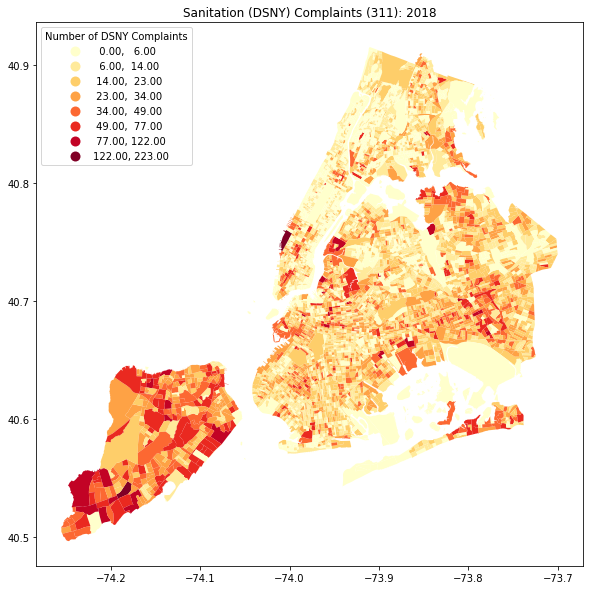

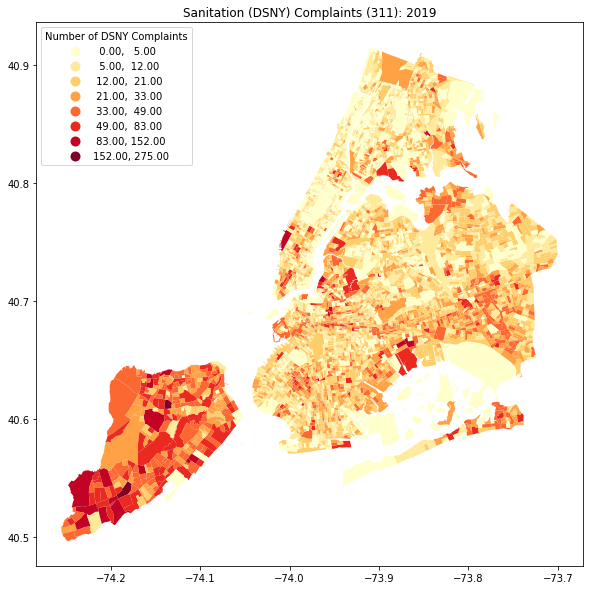

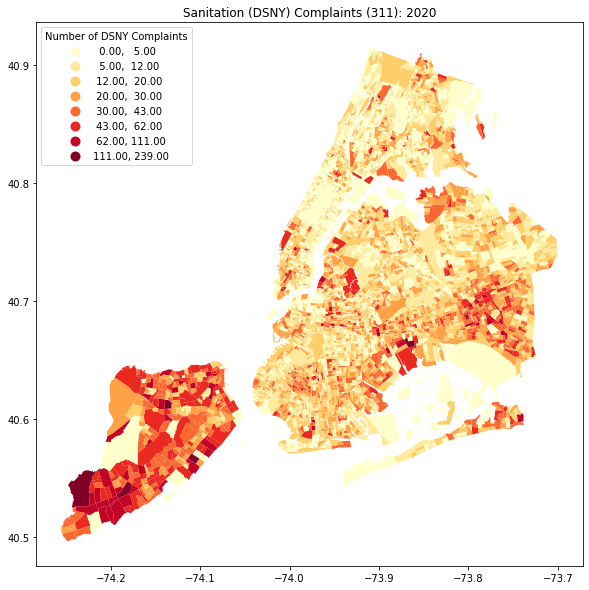

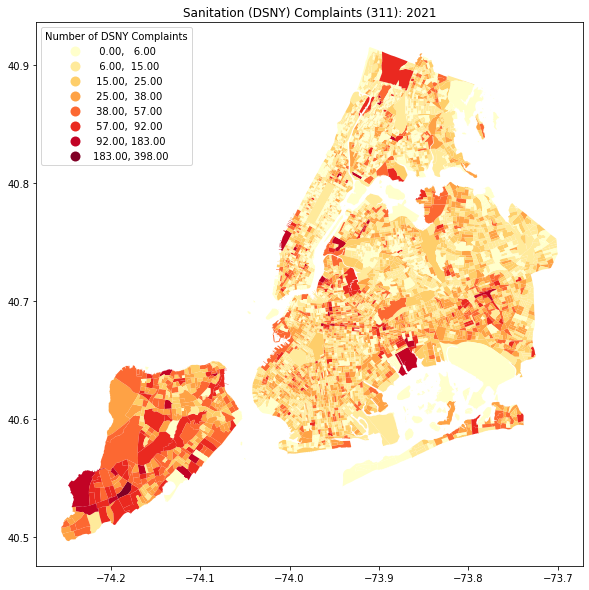

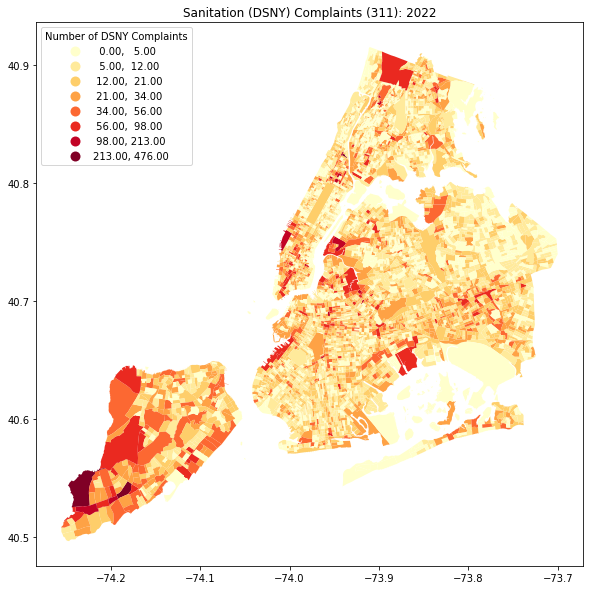

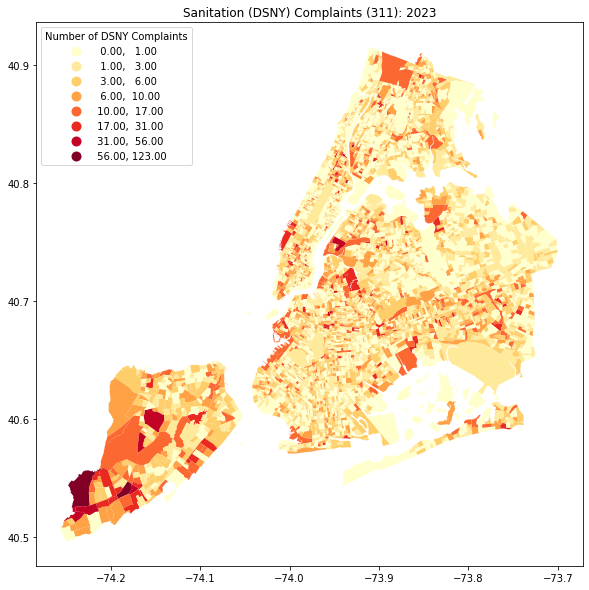

In [149]:
years = sorted(years)
for year in years:
    dsny_complaints_annual_gdf = dsny_complaints_gdf[(dsny_complaints_gdf['year']==year)]
    # Natural Breaks (Jenks)
    fig, ax = plt.subplots(1, 1, figsize=(10, 10))
    dsny_complaints_annual_gdf.plot(column='num_dsny_complaints',
                        ax=ax,
                        cmap='YlOrRd',
                        scheme='natural_breaks',
                        k=8,
                        legend=True,
                        missing_kwds={'color': 'lightgray'},
                        legend_kwds={'loc': 'upper left', 'title': 'Number of DSNY Complaints'})
    plt.title('Sanitation (DSNY) Complaints (311): {0}'.format(year))
    plt.show()

## Plot variables for one year (2021)

In [150]:
dsny_complaints_slim_gdf = dsny_complaints_gdf[(dsny_complaints_gdf['year']=='2021')]
dsny_complaints_slim_gdf.sort_values(by='num_dsny_complaints', ascending=False).head(5)

spatial_id                            name  %OfOwnerOccupiedHousing  \
25821  360850170051  BG0170051, Richmond County, NY                  86.4573   
25902  360850226001  BG0226001, Richmond County, NY                 100.0000   
24138  360810143002    BG0143002, Queens County, NY                  14.9182   
20111  360050265001     BG0265001, Bronx County, NY                   8.0986   
22707  360471220002     BG1220002, Kings County, NY                  31.4961   

       %OfRenterOccupiedHousing  MedianHouseholdIncome  TotalPopulation  \
25821                   13.4446           99719.000000           3036.0   
25902                    0.0000           48893.291526              0.0   
24138                   84.9856           66590.320085           2324.0   
20111                   91.7254           35943.896470           2756.0   
22707                   68.4055           61284.400000           3393.0   

                                                geometry  year  \
25821  POLYGON ((-74.19342 40.53593, -74.19292 40.536...  2021   
25902  POLYGON ((-74.24773 40.54350, -74.24771 40.543...  2021   
24138  POLYGON ((-73.91194 40.76901, -73.91094 40.768...  2021   
20111  POLYGON ((-73.90114 40.86828, -73.90017 40.868...  2021   
22707  POLYGON ((-73.87169 40.66686, -73.87143 40.667...  2021   

       s_Dead_Animal:Residential_sum  s_Dead_Animal:Street_sum  \
25821                            0.0                       3.0   
25902                            0.0                       4.0   
24138                            0.0                       1.0   
20111                            0.0                       4.0   
22707                            0.0                       6.0   

       s_Dog_waste:Street_sum  s_Illegal_Dumping:Street_sum  \
25821                     0.0                          12.0   
25902                     0.0                          45.0   
24138                     0.0                          11.0   
20111                     0.0                           6.0   
22707                     1.0                          32.0   

       s_Trash:Residential_sum  s_Trash:Street_sum  \
25821                     28.0               237.0   
25902                     28.0                79.0   
24138                      2.0               121.0   
20111                      0.0               129.0   
22707                      4.0                17.0   

       s_Trash_MissedService:Street_sum  s_Trash_Overflowing:Street_sum  \
25821                              54.0                             4.0   
25902                              22.0                             1.0   
24138                              24.0                             5.0   
20111                               1.0                             2.0   
22707                              78.0                             0.0   

       s_Trash_Time:Street_sum  s_Trash_Unsecure:Residential_sum  \
25821                      0.0                               5.0   
25902                      0.0                               0.0   
24138                      0.0                               1.0   
20111                      1.0                               0.0   
22707                      0.0                               4.0   

       s_Trash_Unsecure:Street_sum  num_dsny_complaints  
25821                         55.0                398.0  
25902                          4.0                183.0  
24138                          1.0                166.0  
20111                          0.0                143.0  
22707                          0.0                142.0

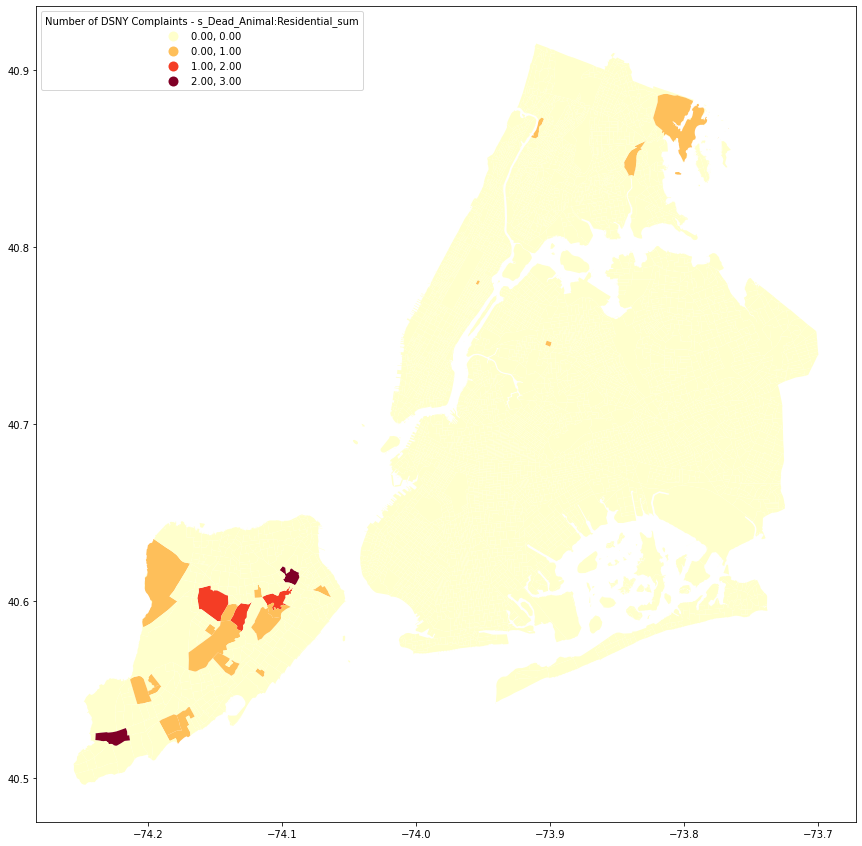

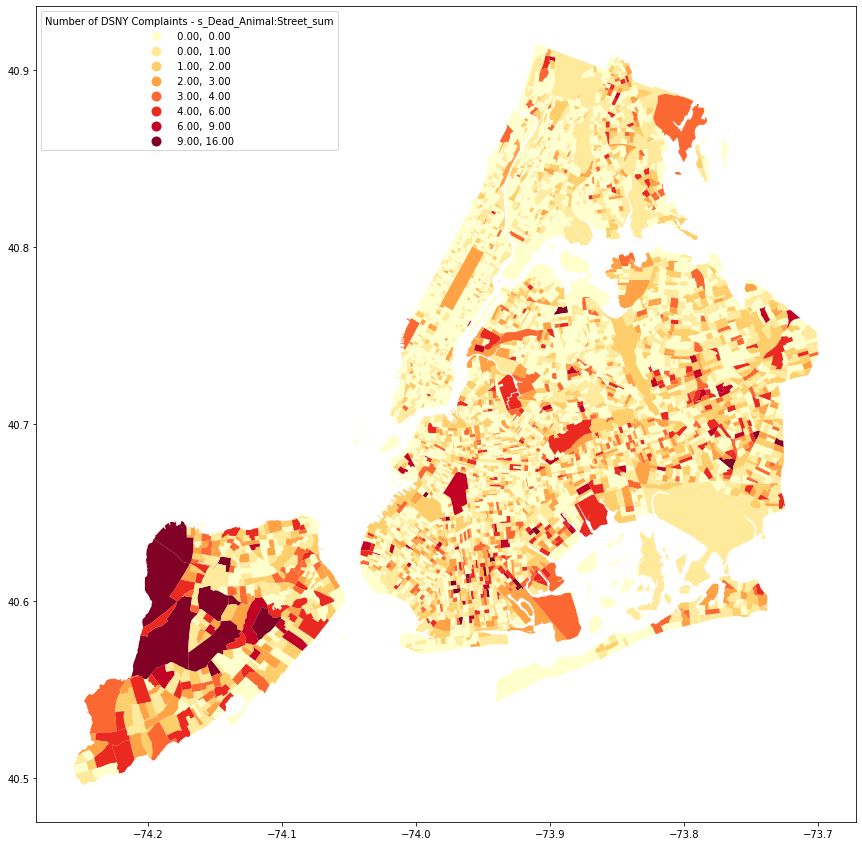

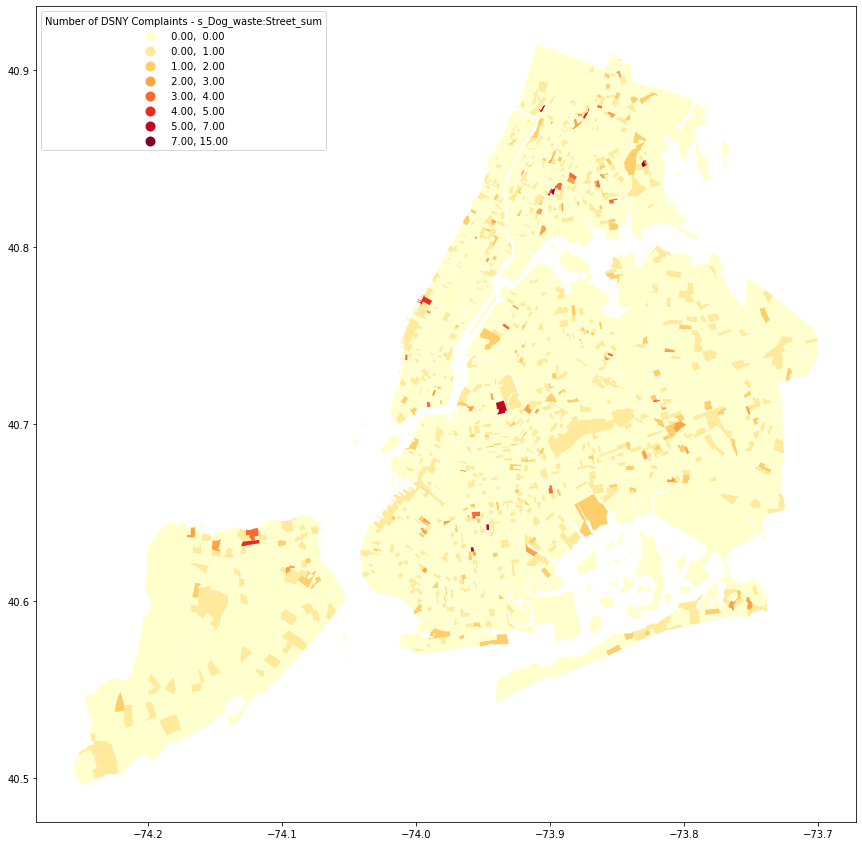

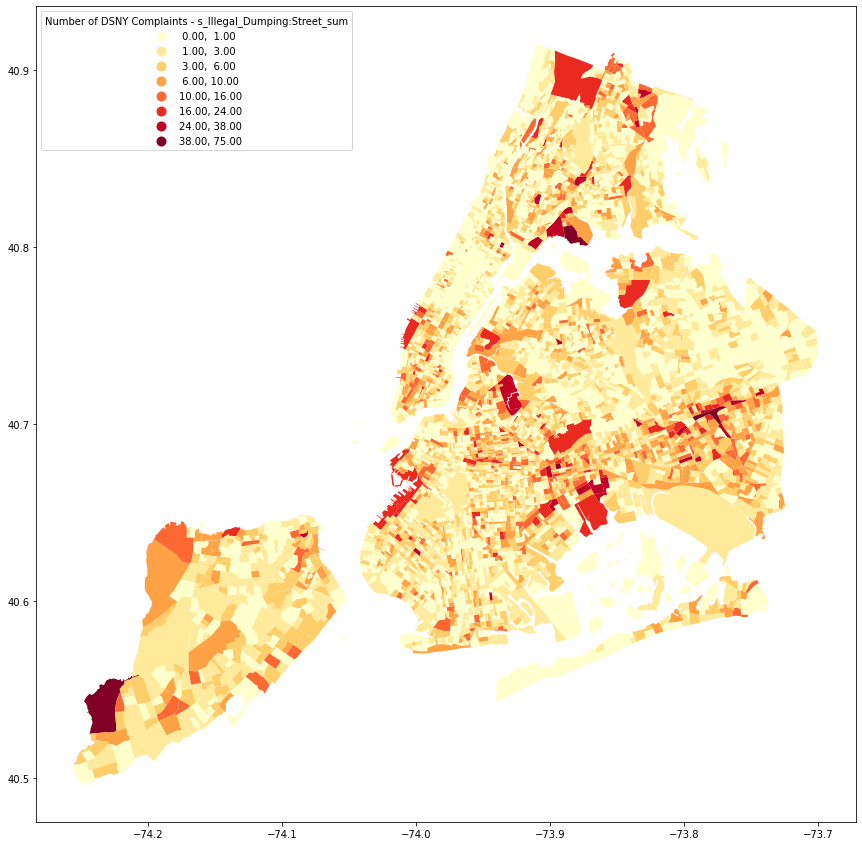

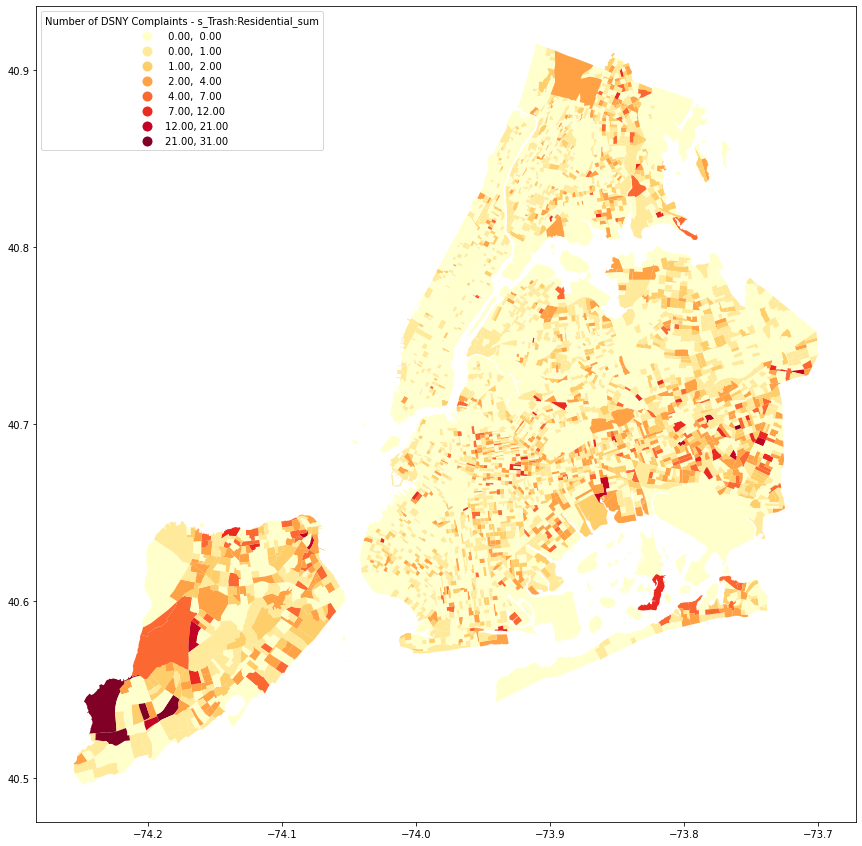

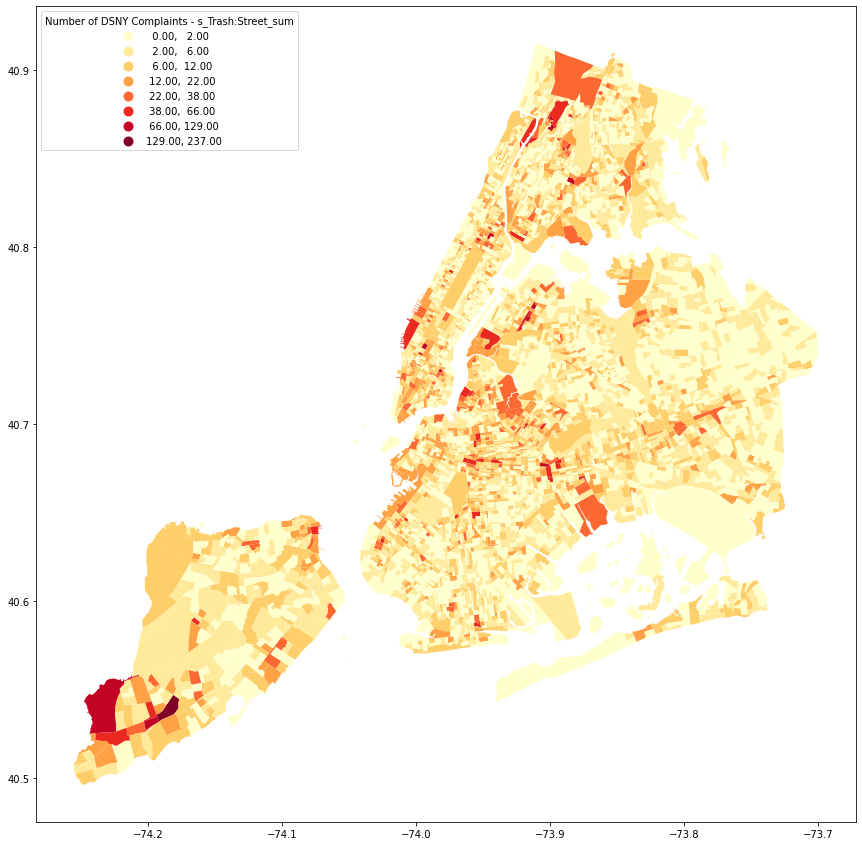

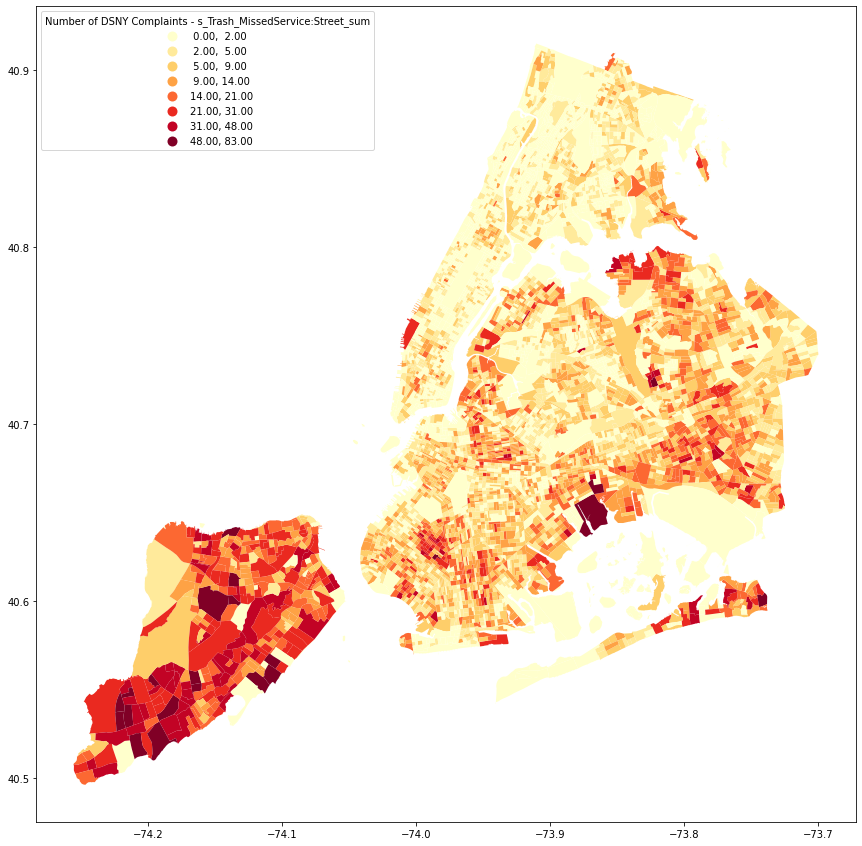

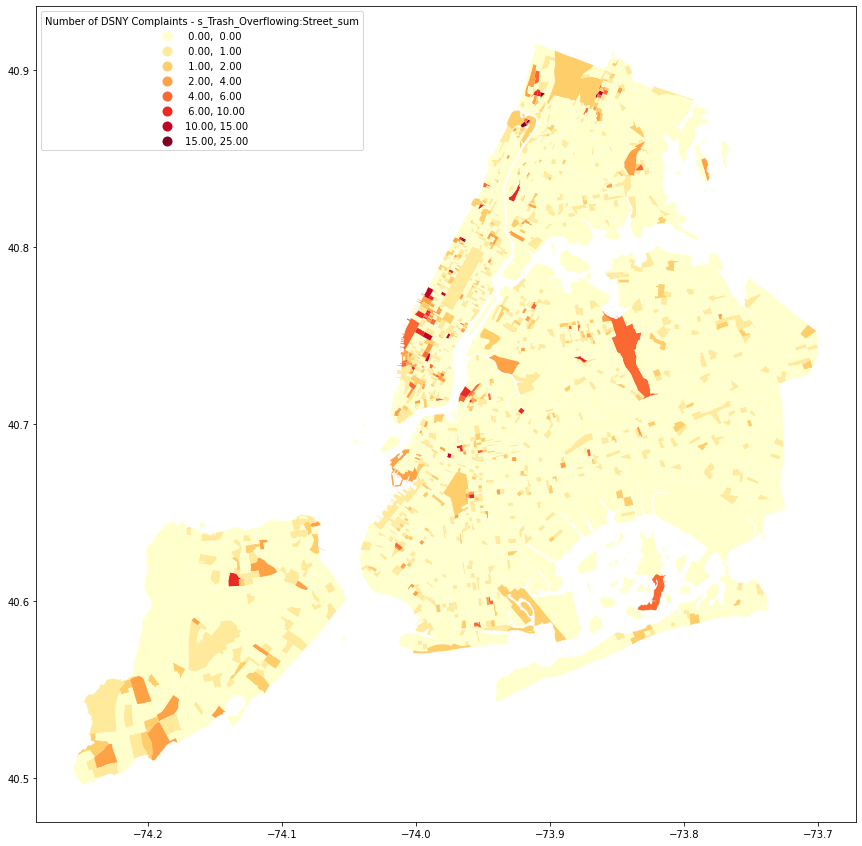

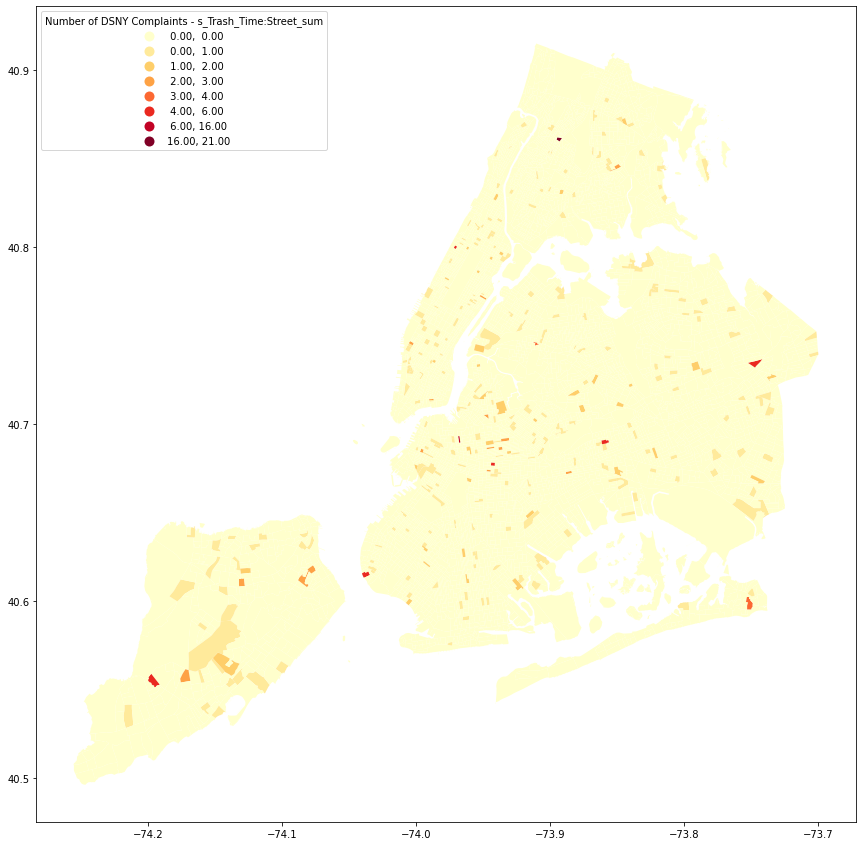

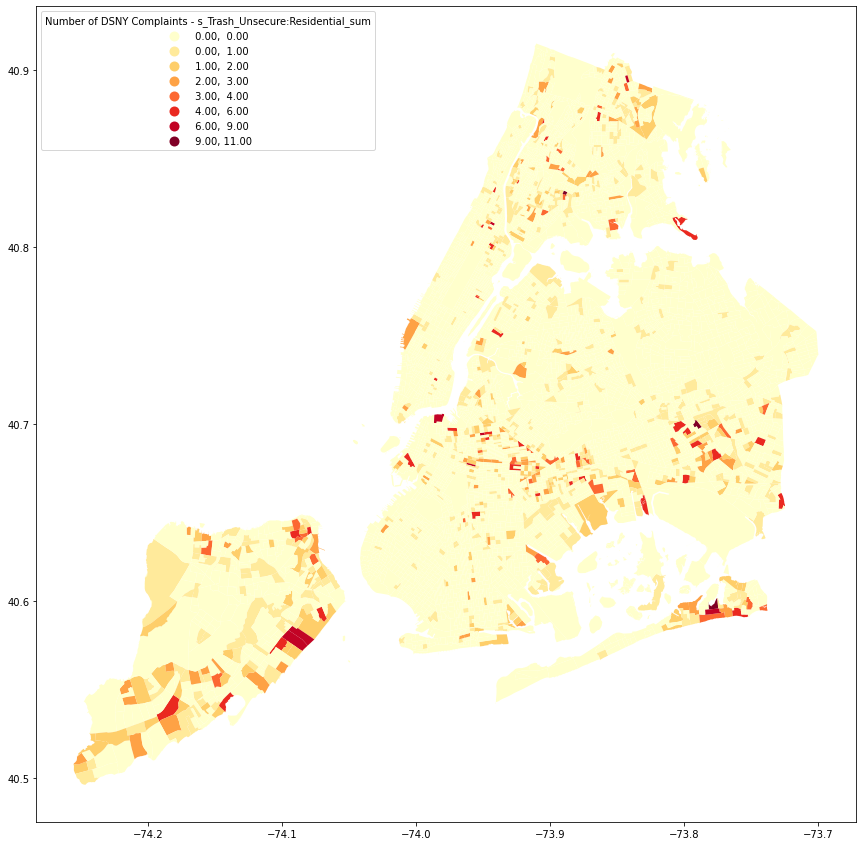

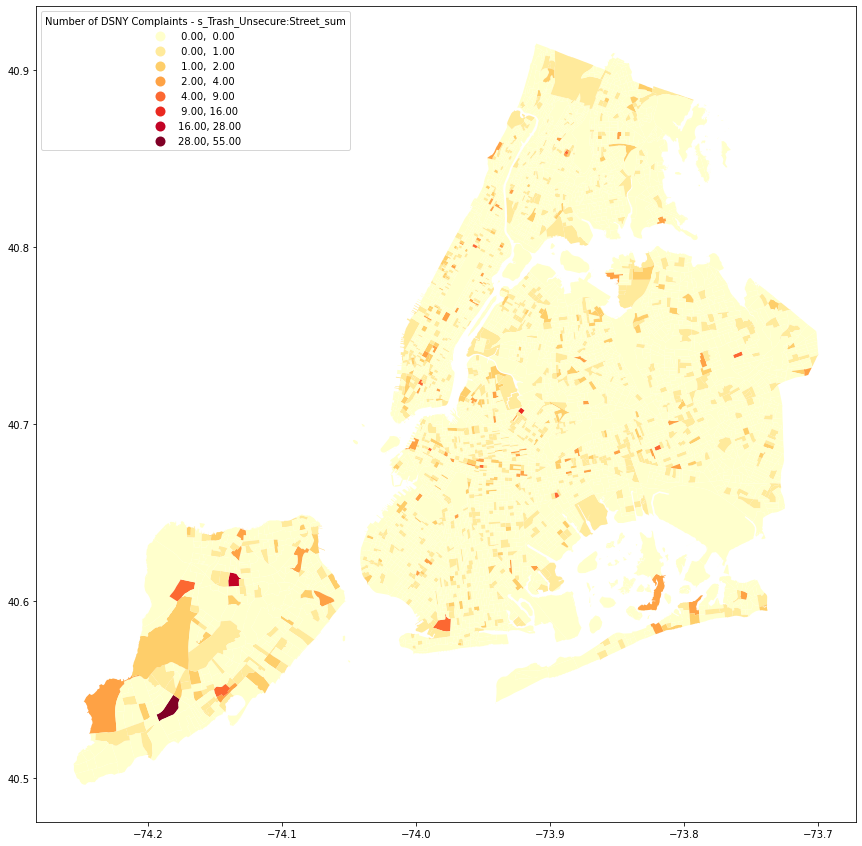

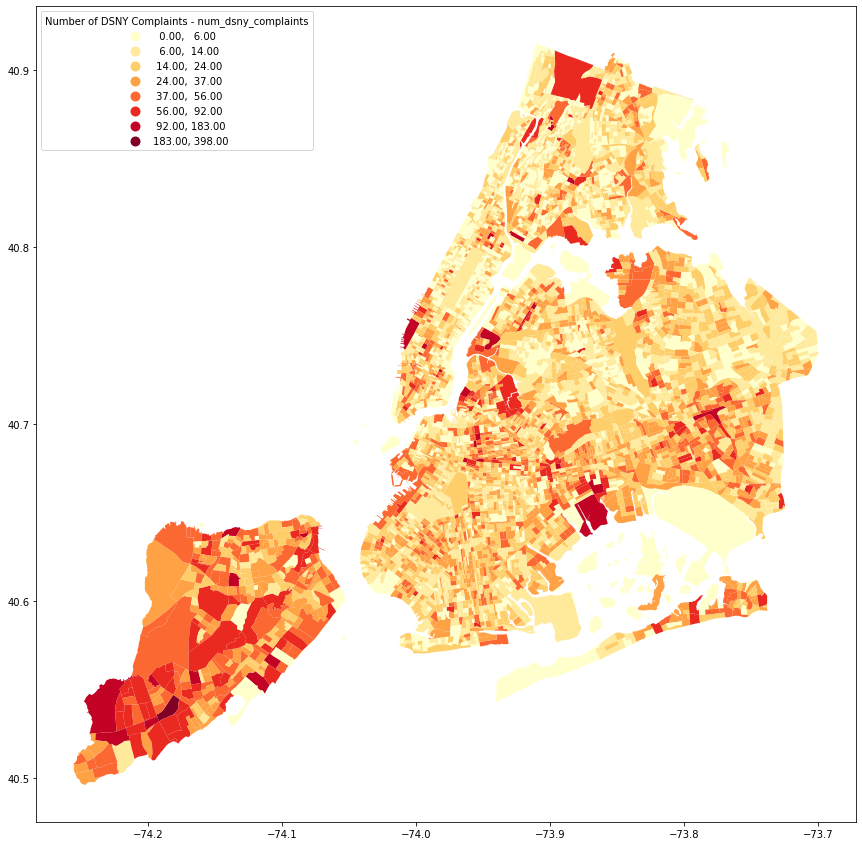

In [151]:
def plot_map(column_name, title):
    fig, ax = plt.subplots(1, 1, figsize=(15, 15))
    dsny_complaints_slim_gdf.plot(column=column_name,
                        ax=ax,
                        cmap='YlOrRd',
                        scheme='natural_breaks',
                        k=8,
                        legend=True,
                        missing_kwds={'color': 'lightgray'},
                        legend_kwds={'loc': 'upper left', 'title': title})
    plt.show()

for column in column_list:
    plot_title = f'Number of DSNY Complaints - {column}'
    plot_map(column, plot_title)

# Export to csv 

Not exporting to GeoJson because the dataset would be very large. Helper code below to load.

In [154]:
export_columns = ['spatial_id'] + dsny_complaints_gdf.columns[7:].to_list()
print(export_columns)
parent_dir = os.path.abspath('..')  # get the absolute path of the parent directory
file_path = os.path.join(parent_dir, 'Data', 'dsny_complaints_per_year.csv')  # construct the file path
dsny_complaints_gdf[export_columns].to_csv(file_path, index=False)

['spatial_id', 'year', 's_Dead_Animal:Residential_sum', 's_Dead_Animal:Street_sum', 's_Dog_waste:Street_sum', 's_Illegal_Dumping:Street_sum', 's_Trash:Residential_sum', 's_Trash:Street_sum', 's_Trash_MissedService:Street_sum', 's_Trash_Overflowing:Street_sum', 's_Trash_Time:Street_sum', 's_Trash_Unsecure:Residential_sum', 's_Trash_Unsecure:Street_sum', 'num_dsny_complaints']


### EXAMPLE 

In [155]:
parent_dir = os.path.abspath('..')  # get the absolute path of the parent directory

# Read Census Block Groups
cb_file_path = os.path.join(parent_dir, 'Data', 'nyc_bgrp.geojson')  # construct the file path
cb_gdf = gpd.read_file(cb_file_path)  # load the GeoJSON file into a GeoDataFrame
print(cb_gdf.dtypes)
print(len(cb_gdf))
cb_gdf.head(2)

spatial_id                    object
name                          object
%OfOwnerOccupiedHousing      float64
%OfRenterOccupiedHousing     float64
MedianHouseholdIncome        float64
TotalPopulation              float64
geometry                    geometry
dtype: object
6493


spatial_id                         name  %OfOwnerOccupiedHousing  \
0  360050001000  BG0001000, Bronx County, NY                      0.0   
1  360050001001  BG0001001, Bronx County, NY                      0.0   

   %OfRenterOccupiedHousing  MedianHouseholdIncome  TotalPopulation  \
0                       0.0                    NaN              0.0   
1                       0.0                    NaN           6472.0   

                                            geometry  
0  MULTIPOLYGON (((-73.89679 40.79616, -73.89681 ...  
1  POLYGON ((-73.89076 40.79782, -73.89076 40.797...

In [157]:
# Read DSNY Complaints
dsny_complaints_file_path = os.path.join(parent_dir, 'Data', 'dsny_complaints_per_year.csv')  # construct the file path
dsny_complaints_df = pd.read_csv(dsny_complaints_file_path)
dsny_complaints_df['spatial_id'] = dsny_complaints_df['spatial_id'].astype(str)
print(len(dsny_complaints_df))
print(dsny_complaints_df.dtypes)
dsny_complaints_df.head(2)


38958
spatial_id                           object
year                                  int64
s_Dead_Animal:Residential_sum       float64
s_Dead_Animal:Street_sum            float64
s_Dog_waste:Street_sum              float64
s_Illegal_Dumping:Street_sum        float64
s_Trash:Residential_sum             float64
s_Trash:Street_sum                  float64
s_Trash_MissedService:Street_sum    float64
s_Trash_Overflowing:Street_sum      float64
s_Trash_Time:Street_sum             float64
s_Trash_Unsecure:Residential_sum    float64
s_Trash_Unsecure:Street_sum         float64
num_dsny_complaints                 float64
dtype: object


spatial_id  year  s_Dead_Animal:Residential_sum  \
0  360050001000  2018                            0.0   
1  360050001001  2018                            0.0   

   s_Dead_Animal:Street_sum  s_Dog_waste:Street_sum  \
0                       0.0                     0.0   
1                       0.0                     0.0   

   s_Illegal_Dumping:Street_sum  s_Trash:Residential_sum  s_Trash:Street_sum  \
0                           0.0                      0.0                 0.0   
1                           0.0                      0.0                 0.0   

   s_Trash_MissedService:Street_sum  s_Trash_Overflowing:Street_sum  \
0                               0.0                             0.0   
1                               0.0                             0.0   

   s_Trash_Time:Street_sum  s_Trash_Unsecure:Residential_sum  \
0                      0.0                               0.0   
1                      0.0                               0.0   

   s_Trash_Unsecure:Street_sum  num_dsny_complaints  
0                          0.0                  0.0  
1                          0.0                  0.0

In [158]:
dsny_complaints_gdf = pd.merge(cb_gdf, dsny_complaints_df, on=['spatial_id'], how='left')

print(len(dsny_complaints_gdf))
dsny_complaints_gdf.head(2)

38958


spatial_id                         name  %OfOwnerOccupiedHousing  \
0  360050001000  BG0001000, Bronx County, NY                      0.0   
1  360050001000  BG0001000, Bronx County, NY                      0.0   

   %OfRenterOccupiedHousing  MedianHouseholdIncome  TotalPopulation  \
0                       0.0                    NaN              0.0   
1                       0.0                    NaN              0.0   

                                            geometry  year  \
0  MULTIPOLYGON (((-73.89679 40.79616, -73.89681 ...  2018   
1  MULTIPOLYGON (((-73.89679 40.79616, -73.89681 ...  2019   

   s_Dead_Animal:Residential_sum  s_Dead_Animal:Street_sum  \
0                            0.0                       0.0   
1                            0.0                       0.0   

   s_Dog_waste:Street_sum  s_Illegal_Dumping:Street_sum  \
0                     0.0                           0.0   
1                     0.0                           0.0   

   s_Trash:Residential_sum  s_Trash:Street_sum  \
0                      0.0                 0.0   
1                      0.0                 0.0   

   s_Trash_MissedService:Street_sum  s_Trash_Overflowing:Street_sum  \
0                               0.0                             0.0   
1                               0.0                             0.0   

   s_Trash_Time:Street_sum  s_Trash_Unsecure:Residential_sum  \
0                      0.0                               0.0   
1                      0.0                               0.0   

   s_Trash_Unsecure:Street_sum  num_dsny_complaints  
0                          0.0                  0.0  
1                          0.0                  0.0